# Showcase: CultPass

## Testing Toolkit

In [1]:
from pathlib import Path
import shutil
import pandas as pd
import os


def rollback_databases() -> None:
    """Delete current DBs and copy backups into place."""

    repo_root = Path(".").resolve()

    cultpass_dst = repo_root / "data" / "external" / "cultpass.db"
    udahub_dst = repo_root / "data" / "core" / "udahub.db"

    backup_dir = repo_root / "data" / "backup"
    cultpass_src = backup_dir / "cultpass.db"
    udahub_src = backup_dir / "udahub.db"

    if not cultpass_src.exists() or not udahub_src.exists():
        raise FileNotFoundError(
            "Missing backup DB(s) in starter/data/backup. "
            "Expected cultpass.db and udahub.db."
        )

    cultpass_dst.parent.mkdir(parents=True, exist_ok=True)
    udahub_dst.parent.mkdir(parents=True, exist_ok=True)

    if cultpass_dst.exists():
        cultpass_dst.unlink()
    if udahub_dst.exists():
        udahub_dst.unlink()

    shutil.copyfile(cultpass_src, cultpass_dst)
    shutil.copyfile(udahub_src, udahub_dst)


def cultpass_db(query: str) -> pd.DataFrame:
    return pd.read_sql_query(
        query, con="sqlite:///./data/external/cultpass.db"
    )


def udahub_db(query: str) -> pd.DataFrame:
    return pd.read_sql_query(
        query, con="sqlite:///./data/core/udahub.db"
    )

## Imports

In [2]:
import sys

# Add the parent directory to Python path to import starter module
sys.path.insert(0, str(Path().resolve().parent))

from starter.agentic.udahub import UdaHubAgent, McpServerList
from langchain_mcp_adapters.client import StreamableHttpConnection
from starter.agentic.udahub import FAQ_AGENT, RESERVATION_AGENT, SUBSCRIPTION_AGENT, BROWSING_AGENT, UdaHubAgent
from starter.agentic.chat_interface import ListChatInterface
from dotenv import load_dotenv
from rich.pretty import Pretty

import chromadb
import asyncio

load_dotenv()

True

## Setup


**Reminder**: Remember to run the MCP servers before executing the rest of this notebook:

```bash
python -m starter.mcp_servers.udahub_mcp
python -m starter.mcp_servers.knowledgebase_mcp
python -m starter.mcp_servers.cultpass_mcp
```

### MCP Server Connections

First we set up the connections to the MCP servers that our agent will interact with.
In our showcase for CultPass Card, this is only one MCP server, whichs lets us interact with the CultPass Card system.

In [3]:
mcp_servers = McpServerList().add_connection(
    "cultpass",
    StreamableHttpConnection(
        url="http://localhost:8003/mcp", transport="streamable_http"
    ),
)

### Agent Selection

UDA-Hub comes with a predefined set of agents and its up to the customer to decide which ones should be available in the interaction of UDA-Hub and their users.
Per default all agents are included, but for the sake of demonstration we will manually select them and plug them into the UDA-Hub agent.

In [4]:
showcase_agents = [
    FAQ_AGENT,
    RESERVATION_AGENT,
    SUBSCRIPTION_AGENT,
    BROWSING_AGENT,
]

### Composing UDA-Hub Chat Agent

In the following we will write a fundtion that returns a new UDA-Hub Chat Agent, so that we can switch sessions when needed.

In [5]:
def uda_hub_chat_agent():
    return UdaHubAgent(
        mcp_servers=mcp_servers, 
        agents=showcase_agents, 
        openai_model="gpt-4.1",
    )

## Database Inspection

First up, in order to understand what the agent is doing we want to have a brief look at the current situation of the CultPass database.

### CultPass Experiences

We can see that CultPass Card currently offers 30 different experiences around the world.

Notice that some experiences are marked as premium, meaning that only users with a premium subscription can book these experiences.

In [6]:
cultpass_db("SELECT * FROM experiences")

,experience_id,title,description,location,when,slots_available,is_premium,created_at,updated_at
0,a6cd9a,Carnival History Tour in Olinda,Discover the origins and vibrant traditions of...,"Pernambuco, Brazil",2026-02-08 03:23:12.544191,21,1,2026-02-07 02:23:12,2026-02-07 02:23:12
1,b99f9b,Sunset Paddleboarding,Glide across calm waters at golden hour with a...,"Santa Catarina, Brazil",2026-02-09 03:23:12.548619,6,0,2026-02-07 02:23:12,2026-02-07 02:23:12
2,68ea3d,Pelourinho Colonial Walk,Wander through colorful streets and learn abou...,"Bahia, Brazil",2026-02-10 03:23:12.548674,16,1,2026-02-07 02:23:12,2026-02-07 02:23:12
3,a5775f,Samba Night at Lapa,Dance the night away at a traditional samba cl...,"Rio de Janeiro, Brazil",2026-02-11 03:23:12.548716,29,0,2026-02-07 02:23:12,2026-02-07 02:23:12
4,fe06ac,Christ the Redeemer Experience,Take a guided trip to one of the New Seven Won...,"Rio de Janeiro, Brazil",2026-02-12 03:23:12.548757,29,1,2026-02-07 02:23:12,2026-02-07 02:23:12
5,139a8a,Modern Art at MASP,Enjoy a guided visit to the São Paulo Museum o...,"São Paulo, Brazil",2026-02-13 03:23:12.548800,29,0,2026-02-07 02:23:12,2026-02-07 02:23:12
6,f217d2,Ibirapuera Park Bike Ride,Cycle through the city's most iconic park with...,"São Paulo, Brazil",2026-02-14 03:23:12.548844,5,1,2026-02-07 02:23:12,2026-02-07 02:23:12
7,72b489,Guided Tour through Vienna,Explore Vienna's rich history and culture with...,"Vienna, Austria",2026-02-15 03:23:12.548884,30,0,2026-02-07 02:23:12,2026-02-07 02:23:12
8,966c93,Danube River Cruise,Experience the beauty of Vienna from the Danub...,"Vienna, Austria",2026-02-16 03:23:12.548925,3,1,2026-02-07 02:23:12,2026-02-07 02:23:12
9,8ad50e,Viennese Coffeehouse Experience,Discover the traditional Viennese coffee cultu...,"Vienna, Austria",2026-02-17 03:23:12.548967,20,0,2026-02-07 02:23:12,2026-02-07 02:23:12


### CultPass Users

Inspecting the userbase of CultPass Card we can see that there are currently 6 users registered.

Notice that some users are blocked, some cancelled their subscription and some chose to upgrade their subscription tier to premium.

In [7]:
cultpass_db("SELECT * FROM users LEFT JOIN subscriptions ON users.user_id = subscriptions.user_id")

,user_id,full_name,email,is_blocked,created_at,updated_at,subscription_id,user_id,status,tier,monthly_quota,started_at,ended_at,created_at,updated_at
0,a4ab87,Alice Kingsley,alice.kingsley@wonderland.com,1,2026-02-07 03:23:12.609707,2026-02-07 02:23:12,38f49f,a4ab87,active,premium,3,2026-02-07 03:23:12.639001,None,2026-02-07 02:23:12,2026-02-07 02:23:12
1,f556c0,Bob Stone,bob.stone@granite.com,0,2026-02-07 03:23:12.609766,2026-02-07 02:23:12,1a9479,f556c0,active,basic,9,2026-02-07 03:23:12.639081,None,2026-02-07 02:23:12,2026-02-07 02:23:12
2,88382b,Cathy Bloom,cathy.bloom@florals.org,0,2026-02-07 03:23:12.609775,2026-02-07 02:23:12,57feda,88382b,active,premium,2,2026-02-07 03:23:12.639123,None,2026-02-07 02:23:12,2026-02-07 02:23:12
3,888fb2,David Noir,david.noir@shadowmail.com,1,2026-02-07 03:23:12.609780,2026-02-07 02:23:12,d3e593,888fb2,active,basic,9,2026-02-07 03:23:12.639163,None,2026-02-07 02:23:12,2026-02-07 02:23:12
4,f1f10d,Eva Green,eva.green@ecosoul.net,0,2026-02-07 03:23:12.609785,2026-02-07 02:23:12,0a2555,f1f10d,cancelled,basic,8,2026-02-07 03:23:12.639203,None,2026-02-07 02:23:12,2026-02-07 02:23:12
5,e6376d,Frank Ocean,frank.ocean@seawaves.io,0,2026-02-07 03:23:12.609789,2026-02-07 02:23:12,be6c45,e6376d,active,basic,9,2026-02-07 03:23:12.639243,None,2026-02-07 02:23:12,2026-02-07 02:23:12


### CultPass Reservations

In [8]:
cultpass_db("SELECT * FROM reservations LEFT JOIN users ON reservations.user_id = users.user_id")

,reservation_id,user_id,experience_id,status,created_at,updated_at,user_id,full_name,email,is_blocked,created_at,updated_at
0,802eff,a4ab87,c47554,reserved,2026-02-07 02:23:12,2026-02-07 02:23:12,a4ab87,Alice Kingsley,alice.kingsley@wonderland.com,1,2026-02-07 03:23:12.609707,2026-02-07 02:23:12
1,0126e1,a4ab87,b99f9b,reserved,2026-02-07 02:23:12,2026-02-07 02:23:12,a4ab87,Alice Kingsley,alice.kingsley@wonderland.com,1,2026-02-07 03:23:12.609707,2026-02-07 02:23:12


### Uda-Hub Accounts

From the accounts table we can see that only CultPass Card is currently connected to UDA-Hub.

In [9]:
udahub_db("SELECT * FROM accounts")

,account_id,account_name,account_description,created_at,updated_at
0,cultpass,CultPass Card,CultPass Card is a digital membership card tha...,2026-02-07 02:23:40,2026-02-07 02:23:40


### UDA-Hub Users

Furthermore we see, that only one user of CultPass Card, namely Alice Kingsley, so far interacted with UDA-Hub.

In [10]:
udahub_db("SELECT * FROM users")

,user_id,account_id,external_user_id,user_name,created_at,updated_at
0,662dfd3a-b000-49c1-b4c2-5259a3558daf,cultpass,a4ab87,Alice Kingsley,2026-02-07 02:23:40,2026-02-07 02:23:40
1,24920d3e-a4ef-4eeb-a585-be73b2e15dd7,cultpass,f556c0,Bob Stone,2026-02-08 02:25:27,2026-02-08 02:25:27


### UDA Hub Knowledge

Inspecting the knowledge table of UDA-Hub database we can see that there are currently 14 enties stored for the usage of FAQs.

In [11]:
udahub_db("SELECT * FROM knowledge")

,article_id,account_id,title,content,tags,created_at,updated_at
0,a019341c-643a-4a17-95fe-2623a38cadaf,cultpass,How to Reserve a Spot for an Event,If a user asks how to reserve an event:\n\n- G...,"reservation, events, booking, attendance",2026-02-07 02:23:40,2026-02-07 02:23:40
1,8907406f-9f93-474e-ac48-7a910675dda9,cultpass,What's Included in a CultPass Subscription,Each user is entitled to 4 cultural experience...,"subscription, benefits, pricing, access",2026-02-07 02:23:40,2026-02-07 02:23:40
2,7cf2f635-ca82-4d96-b32b-4307063eaf54,cultpass,How to Cancel or Pause a Subscription,Users can manage their subscription via the ap...,"cancelation, pause, subscription, billing",2026-02-07 02:23:40,2026-02-07 02:23:40
3,07e2a0fd-5770-49a2-8270-da2301c1e86c,cultpass,How to Handle Login Issues?,Most login issues are resolved with password r...,"login, password, access, escalation",2026-02-07 02:23:40,2026-02-07 02:23:40
4,a25e7353-7645-438b-86a1-34a0ba33131c,cultpass,How to Update Payment Information?,Users can update their payment details through...,"payment, billing, update, support",2026-02-07 02:23:40,2026-02-07 02:23:40
5,0f3dee61-c43f-4a26-88d1-407cb1651ccb,cultpass,Can I cancel my reservation?,Reservations can be canceled up to 24 hours be...,"reservation, cancellation, policy, refund",2026-02-07 02:23:40,2026-02-07 02:23:40
6,ae19e9df-bafb-4375-a1be-1474cfe9e149,cultpass,How do I change my password?,To change your password:\n\n- Open the CultPas...,"password, security, account, update",2026-02-07 02:23:40,2026-02-07 02:23:40
7,4b0697b5-8bb4-4486-a914-5aaffc2417ff,cultpass,Do I get a confirmation email after reserving ...,"Yes, you will receive a confirmation email aft...","confirmation, email, reservation, support",2026-02-07 02:23:40,2026-02-07 02:23:40
8,5d80ae55-75c6-4a89-905f-82bf58391274,cultpass,Can I get more than 4 experiences per month?,The standard CultPass subscription includes 4 ...,"subscription, additional, purchase, events",2026-02-07 02:23:40,2026-02-07 02:23:40
9,bcd6e4b1-f32c-49ed-87ea-ee392b268459,cultpass,Where do you offer experiences?,CultPass offers experiences in various cities ...,"locations, availability, events, expansion",2026-02-07 02:23:40,2026-02-07 02:23:40


## ChromaDB Knowledge Base

As outlined in the README.md, our agents are not going to use the relational databases for extracting knowledge or the experiences of CultPass Card.
Instead, we will use a vector database powered by ChromaDB that contains the experiences of CultPass Card as well as the knowloedge from UDA-Hubs knowledge table.


**Hint**: The knwoledge is synchronized upon starting a new run through the workflow graph, so that the ChromaDB is always up-to-date.

In [12]:
chroma_client = chromadb.PersistentClient(path="../chroma_data")
Pretty(chroma_client.list_collections())

[Collection(name=udahub), Collection(name=cultpass)]

As we can see, there are two collections in the ChromaDB. One for the CultPass experiences and one for the UDA-Hub knowledge base.

### UDA-Hub Collection

The `udahub` collection contains the same information as the relational database table above. The big difference is that the entries are vectorized and can be used for similarity search.

In [13]:
Pretty(chroma_client.get_collection("udahub").get(limit=3))

{
    'ids': [
        'knowledge_a019341c-643a-4a17-95fe-2623a38cadaf',
        'knowledge_8907406f-9f93-474e-ac48-7a910675dda9',
        'knowledge_7cf2f635-ca82-4d96-b32b-4307063eaf54'
    ],
    'embeddings': None,
    'documents': [
        'If a user asks how to reserve an event:\n\n- Guide them to the CultPass app\n- Instruct them to browse the
experience catalog and tap \'Reserve\'\n- If it\'s a premium or limited event, check if reservation confirmation is
required via email\n- Remind them to arrive at least 15 minutes early with their QR code visible\n\n**Suggested 
phrasing:**\n"You can reserve an experience by opening the CultPass app, selecting your desired event, and tapping 
\'Reserve\'. Be sure to arrive 15 minutes early with your QR code ready."',
        'Each user is entitled to 4 cultural experiences per month, which may include:\n- Art exhibitions\n- Museum
entries\n- Music concerts\n- Film screenings and more\n\nSome premium experiences may require an additional fee 
(visible in the app).\n\n**Suggested phrasing:**\n"Your CultPass subscription includes 4 curated experiences each 
month. You can choose from museums, concerts, film events and more. Premium events may have an extra cost, which is
shown during reservation."',
        'Users can manage their subscription via the app > \'My Account\' > \'Manage Plan\'.\n\n- Cancel: Effective
at the end of the billing cycle\n- Pause: Preserves user data, resumes automatically when reactivated\n- Do NOT 
offer refunds unless approved by support lead\n\n**Suggested phrasing:**\n"You can cancel or pause your 
subscription at any time via the \'My Account\' section in the CultPass app. Cancelation takes effect at the end of
your billing cycle."'
    ],
    'uris': None,
    'included': ['metadatas', 'documents'],
    'data': None,
    'metadatas': [
        {
            'account_id': 'cultpass',
            'type': 'knowledge',
            'tags': 'reservation, events, booking, attendance',
            'article_id': 'a019341c-643a-4a17-95fe-2623a38cadaf',
            'title': 'How to Reserve a Spot for an Event'
        },
        {
            'type': 'knowledge',
            'title': "What's Included in a CultPass Subscription",
            'tags': 'subscription, benefits, pricing, access',
            'article_id': '8907406f-9f93-474e-ac48-7a910675dda9',
            'account_id': 'cultpass'
        },
        {
            'title': 'How to Cancel or Pause a Subscription',
            'type': 'knowledge',
            'article_id': '7cf2f635-ca82-4d96-b32b-4307063eaf54',
            'account_id': 'cultpass',
            'tags': 'cancelation, pause, subscription, billing'
        }
    ]
}

### CultPass Collection

The `cultpass` collection contains all the experiences of CultPass Card, also vectorized for similarity search.

In [14]:
Pretty(chroma_client.get_collection("cultpass").get(limit=5))

{
    'ids': [
        'experience_a6cd9a',
        'experience_b99f9b',
        'experience_68ea3d',
        'experience_a5775f',
        'experience_fe06ac'
    ],
    'embeddings': None,
    'documents': [
        "Discover the origins and vibrant traditions of Pernambuco's Carnival.",
        'Glide across calm waters at golden hour with all gear included.',
        'Wander through colorful streets and learn about Afro-Brazilian history.',
        'Dance the night away at a traditional samba club in the Lapa arches.',
        'Take a guided trip to one of the New Seven Wonders of the World with historical context.'
    ],
    'uris': None,
    'included': ['metadatas', 'documents'],
    'data': None,
    'metadatas': [
        {'experience_id': 'a6cd9a', 'type': 'experience', 'title': 'Carnival History Tour in Olinda'},
        {'type': 'experience', 'title': 'Sunset Paddleboarding', 'experience_id': 'b99f9b'},
        {'title': 'Pelourinho Colonial Walk', 'experience_id': '68ea3d', 'type': 'experience'},
        {'type': 'experience', 'title': 'Samba Night at Lapa', 'experience_id': 'a5775f'},
        {'type': 'experience', 'title': 'Christ the Redeemer Experience', 'experience_id': 'fe06ac'}
    ]
}

## Demo Cases

In the following sections we will demonstrate various capabilities of the implementation.

### Demo 1: First Interaction

| Parameter | Value |
| --- | --- |
| Cultpass User | `Bob Stone` |
| Cultpass User-ID | `f556c0` |
| UDA-Hub Account | `cultpass` |

As you can see, Bob Stone did not interact with UDA-Hub before.

In [15]:
udahub_db("SELECT * FROM users WHERE external_user_id = 'f556c0'")

,user_id,account_id,external_user_id,user_name,created_at,updated_at
0,24920d3e-a4ef-4eeb-a585-be73b2e15dd7,cultpass,f556c0,Bob Stone,2026-02-08 02:25:27,2026-02-08 02:25:27


In [16]:
chat_interface = ListChatInterface([
    "Do you have anything cool in Japan?",
    "The photo shooting sounds great. Can you tell me more about it?",
    "That's it for now, thanks!",
])

chat_agent = uda_hub_chat_agent()
continuation_info = await chat_agent.start_chat(
    account_id="cultpass",
    external_user_id="f556c0",
    chat_interface=chat_interface,
)
Pretty(continuation_info)

(You can quit the chat by sending an empty message)


Starting UDA Hub chat...
Thread ID: 2f6e6ba8-8ae3-461b-906a-640d5d8def43

Synchronizing knowledge base...
...sync_cultpass_experiences()
...sync_udahub_knowledgebase()
Knowledge base synchronized.

Welcome Bob Stone!
I am UDA-Hub and I will be helping you on behalf of CultPass Card.
> Do you have anything cool in Japan?
Here are some cool experiences available in Japan through CultPass Card:

1. Kimono Photography Session (Product ID: da2c55): Dress in a traditional kimono and have a professional photoshoot in scenic Kyoto locations.
2. Kyoto Temple Tour (Product ID: e3a349): Visit some of Kyoto's most famous temples and learn about their history and architecture.
3. Tea Ceremony in Kyoto (Product ID: 7c42f2): Participate in a traditional Japanese tea ceremony and learn about its cultural significance.
4. Gion District Walk (Product ID: dafe6f): Explore the historic Gion district, known for its traditional wooden machiya houses and 

{'thread_id': '2f6e6ba8-8ae3-461b-906a-640d5d8def43', 'ticket_id': 'f98ecedf-cae5-4feb-89a1-694e5435fedc'}

**LangSmith Trace:**

https://eu.smith.langchain.com/public/acbb4511-9a69-4bc6-884d-d2d2825ff708/r

#### Results

On the UDA-Hub Database we can see several changes after the interaction.

First of all a new user was created for Bob Stone, with the external user id `f556c0` for the account `cultpass`.

In [17]:
udahub_db("SELECT * FROM users WHERE external_user_id = 'f556c0'")

,user_id,account_id,external_user_id,user_name,created_at,updated_at
0,24920d3e-a4ef-4eeb-a585-be73b2e15dd7,cultpass,f556c0,Bob Stone,2026-02-08 02:25:27,2026-02-08 02:25:27


Furthermore a new ticket has been created.

In [18]:
udahub_db(f"SELECT * FROM tickets WHERE ticket_id = '{continuation_info.get("ticket_id")}'")

,ticket_id,account_id,user_id,channel,summary,created_at
0,f98ecedf-cae5-4feb-89a1-694e5435fedc,cultpass,24920d3e-a4ef-4eeb-a585-be73b2e15dd7,chat,Customer inquired about unique experiences in ...,2026-02-08 02:38:26


Linked with this ticket is also the entire chat history.

In [19]:
udahub_db(f"SELECT * FROM ticket_messages WHERE ticket_id = '{continuation_info.get("ticket_id")}'")

,message_id,ticket_id,role,content,created_at
0,bd808c8e-8fcd-4ddd-bfef-3605ffbf8b67,f98ecedf-cae5-4feb-89a1-694e5435fedc,ai,Welcome Bob Stone!\nI am UDA-Hub and I will be...,2026-02-08 02:38:26
1,99a5acf8-df6a-48c7-a2b1-f4fc499da36f,f98ecedf-cae5-4feb-89a1-694e5435fedc,user,Do you have anything cool in Japan?,2026-02-08 02:38:26
2,f382db89-3e6e-45e5-b6dd-4a2acd1728b1,f98ecedf-cae5-4feb-89a1-694e5435fedc,ai,Here are some cool experiences available in Ja...,2026-02-08 02:38:26
3,5e11681f-21fb-4d56-a117-28d789817b38,f98ecedf-cae5-4feb-89a1-694e5435fedc,user,The photo shooting sounds great. Can you tell ...,2026-02-08 02:38:26
4,dc409aca-c00d-452b-83c3-eb679d1e031c,f98ecedf-cae5-4feb-89a1-694e5435fedc,ai,"The ""Kimono Photography Session"" (Product ID: ...",2026-02-08 02:38:26
5,d7721d41-2043-43a6-b8a1-124f649a9c38,f98ecedf-cae5-4feb-89a1-694e5435fedc,user,"That's it for now, thanks!",2026-02-08 02:38:26
6,37a5d1da-5cb0-4189-bc6d-5f927222e9b0,f98ecedf-cae5-4feb-89a1-694e5435fedc,ai,You're welcome! If you have any more questions...,2026-02-08 02:38:26


And metadata about the ticket, such as the status, tags and so on.

In [20]:
udahub_db(f"SELECT * FROM ticket_metadata WHERE ticket_id = '{continuation_info.get("ticket_id")}'")

,ticket_id,status,main_issue_type,tags,created_at,updated_at
0,f98ecedf-cae5-4feb-89a1-694e5435fedc,open,None,"Japan,experiences,kimono,photoshoot,Kyoto",2026-02-08 02:38:26,2026-02-08 02:38:26


### Demo 2: Short-term and Long-term Memory

In this demo we want to demonstraten the ability to continue a session while it is still alive and also to continue a session after it has ended, showcasing the short-term and long-term memory capabilities of the agent.

| Parameter | Value |
| --- | --- |
| Cultpass User | `Cathy Bloom` |
| Cultpass User-ID | `88382b` |
| UDA-Hub Account | `cultpass` |

In [21]:
chat_interface = ListChatInterface([
    "I am in kyoto. Do you have any recommendations?",
    "Oh, I always wanted to attend a tea ceremony",
    "", # Empty message terminates the chat
])

chat_agent = uda_hub_chat_agent()
continuation_info = await chat_agent.start_chat(
    account_id="cultpass",
    external_user_id="88382b",
    thread_id="Demo_2_Thread",
    chat_interface=chat_interface,
)

(You can quit the chat by sending an empty message)


Starting UDA Hub chat...
Thread ID: Demo_2_Thread

Synchronizing knowledge base...
...sync_cultpass_experiences()
...sync_udahub_knowledgebase()
Knowledge base synchronized.

Welcome Cathy Bloom!
I am UDA-Hub and I will be helping you on behalf of CultPass Card.
It seems like I am serving you the first time. I created a new UDA Hub user for you to keep context.
Your user ID with me is 876e7b24-86f2-4318-819b-952f2693dffe

> I am in kyoto. Do you have any recommendations?
Here are some recommendations for experiences in Kyoto available with your CultPass Card:

1. Kimono Photography Session (Product ID: da2c55): Dress in a traditional kimono and have a professional photoshoot in scenic Kyoto locations.
2. Kyoto Temple Tour (Product ID: e3a349): Visit some of Kyoto's most famous temples and learn about their history and architecture.
3. Tea Ceremony in Kyoto (Product ID: 7c42f2): Participate in a traditional Japanese tea ceremony and 

**LangSmith Trace:**

https://eu.smith.langchain.com/public/2119b6c5-3326-41a5-b386-31a9b74bd7f5/r

Next we are picking up the conversation by using the same Chat Agent instance and `thread_id`.

In [22]:
chat_interface = ListChatInterface([
    "When does it take place?",
    "I need to check with my friend. I will get back to you. That's it for now, thanks!",
])

continuation_info = await chat_agent.start_chat(
    account_id="cultpass",
    external_user_id="88382b",
    thread_id="Demo_2_Thread",
    chat_interface=chat_interface,
)

Pretty(continuation_info)

(You can quit the chat by sending an empty message)


Starting UDA Hub chat...
Thread ID: Demo_2_Thread

Synchronizing knowledge base...
...sync_cultpass_experiences()
...sync_udahub_knowledgebase()
Knowledge base synchronized.

> When does it take place?
The 'Tea Ceremony in Kyoto' (Product ID: 7c42f2) is scheduled to take place on February 18, 2026, at 03:23 AM (local time). There are currently 16 slots available for this premium experience.

Would you like more details or assistance with anything else?
> I need to check with my friend. I will get back to you. That's it for now, thanks!
You're welcome! Take your time to check with your friend. If you have any more questions or need assistance in the future, feel free to reach out. Have a great day!

You can continue this conversation anytime by providing the ticket ID: 842db544-0589-487f-a96b-8f8ce67ff7a7



{'thread_id': 'Demo_2_Thread', 'ticket_id': '842db544-0589-487f-a96b-8f8ce67ff7a7'}

**LangSmith Trace:**

https://eu.smith.langchain.com/public/87dbb0b6-d267-4d45-a50f-6b5272b0c1db/r

As we can see the agent was able to pick up the conversation right where it was left off, showcasing the short-term memory capabilities.

Please notice neither needed the agent to retrieve anything from the `ticket_messages` table (graph node `enrichment`) nor was it necessary to validate the user again (graph node `validation`).

See the screenshots of the LangSmith traces. You can also investigate the traces yourself as the traces are shared.

**First Chat**

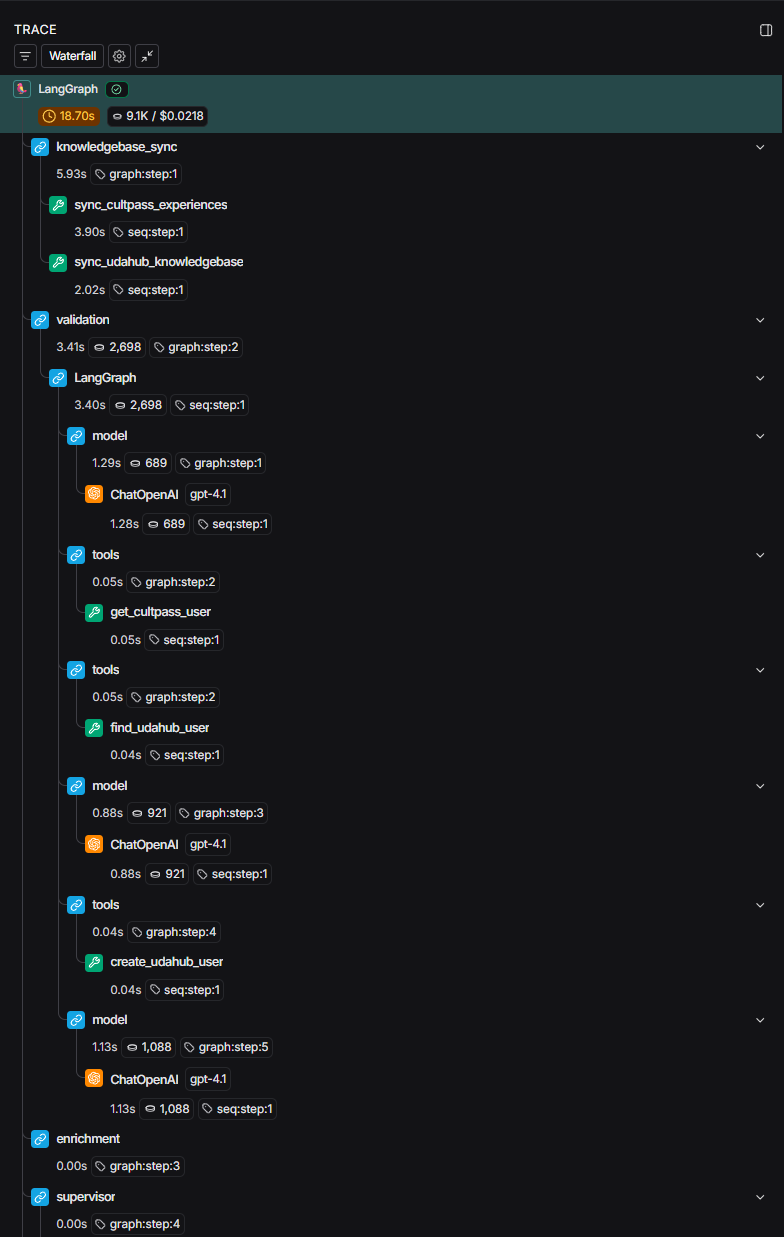


**Second chat**

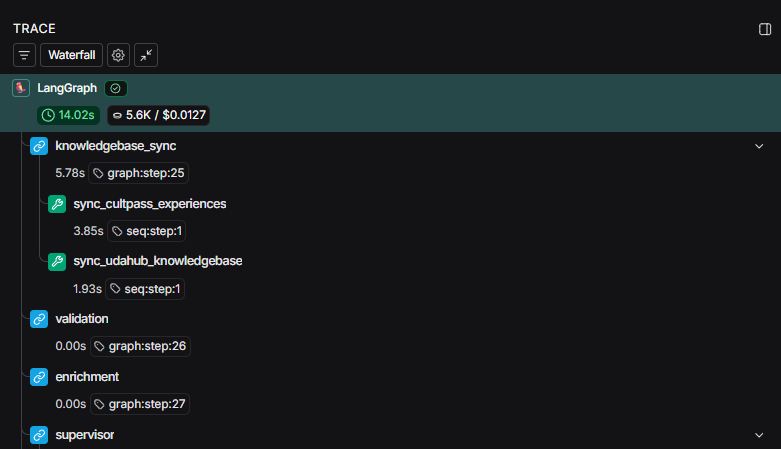

Additionally we can see in the database that the entire conversation is part of the same ticket, despite being split up in different runs.

In [23]:
udahub_db(f"SELECT * FROM ticket_messages WHERE ticket_id = '{continuation_info.get("ticket_id")}'")

,message_id,ticket_id,role,content,created_at
0,912c6b76-6612-46b6-b6f7-2ccd7ab4def1,842db544-0589-487f-a96b-8f8ce67ff7a7,ai,Welcome Cathy Bloom!\nI am UDA-Hub and I will ...,2026-02-08 02:38:44
1,11b13f52-646a-4eed-98c3-a711ac2c31d3,842db544-0589-487f-a96b-8f8ce67ff7a7,ai,It seems like I am serving you the first time....,2026-02-08 02:38:44
2,a881dbb1-a9ae-48ce-9f09-20dbd76e827f,842db544-0589-487f-a96b-8f8ce67ff7a7,user,I am in kyoto. Do you have any recommendations?,2026-02-08 02:38:44
3,60a1d3ad-df35-4430-a980-78a7ae8cb121,842db544-0589-487f-a96b-8f8ce67ff7a7,ai,Here are some recommendations for experiences ...,2026-02-08 02:38:44
4,9671a121-0cf5-41e9-97c1-72a827ddec51,842db544-0589-487f-a96b-8f8ce67ff7a7,user,"Oh, I always wanted to attend a tea ceremony",2026-02-08 02:38:44
5,7244a637-2cbd-4818-82f1-006f32ea5eb3,842db544-0589-487f-a96b-8f8ce67ff7a7,ai,The 'Tea Ceremony in Kyoto' (Product ID: 7c42f...,2026-02-08 02:38:44
6,6dc86407-7c0a-441b-8f63-49edab1bccb2,842db544-0589-487f-a96b-8f8ce67ff7a7,user,When does it take place?,2026-02-08 02:38:57
7,09425063-e626-4606-9524-e5a08cae0631,842db544-0589-487f-a96b-8f8ce67ff7a7,ai,The 'Tea Ceremony in Kyoto' (Product ID: 7c42f...,2026-02-08 02:38:57
8,5e072dc0-0116-4530-be7f-1d040c823c8f,842db544-0589-487f-a96b-8f8ce67ff7a7,user,I need to check with my friend. I will get bac...,2026-02-08 02:38:57
9,215212cf-1350-44a3-aebc-309c7fff6352,842db544-0589-487f-a96b-8f8ce67ff7a7,ai,You're welcome! Take your time to check with y...,2026-02-08 02:38:57


Next we are picking up the conversation again, but this time after the session has ended, showcasing the long-term memory capabilities.

In [24]:
chat_interface = ListChatInterface([
    "Okay, that works out. I want to make a reservation for it please.",
    "Yes, confirmed.",
    "That's it. Thanks!",
])

chat_agent = uda_hub_chat_agent()
continuation_info = await chat_agent.start_chat(
    account_id="cultpass",
    external_user_id="88382b",
    ticket_id=continuation_info.get("ticket_id"),
    chat_interface=chat_interface,
)

(You can quit the chat by sending an empty message)


Starting UDA Hub chat...
Thread ID: 2f6e6ba8-8ae3-461b-906a-640d5d8def43

Synchronizing knowledge base...
...sync_cultpass_experiences()
...sync_udahub_knowledgebase()
Knowledge base synchronized.


Loaded 10 messages from long-term memory for ticket_id 842db544-0589-487f-a96b-8f8ce67ff7a7

Welcome Cathy Bloom!
I am UDA-Hub and I will be helping you on behalf of CultPass Card.
It seems like I am serving you the first time. I created a new UDA Hub user for you to keep context.
Your user ID with me is 876e7b24-86f2-4318-819b-952f2693dffe

> I am in kyoto. Do you have any recommendations?
Here are some recommendations for experiences in Kyoto available with your CultPass Card:

1. Kimono Photography Session (Product ID: da2c55): Dress in a traditional kimono and have a professional photoshoot in scenic Kyoto locations.
2. Kyoto Temple Tour (Product ID: e3a349): Visit some of Kyoto's most famous temples and learn about their history and

**LangSmith Trace:**

https://eu.smith.langchain.com/public/b5290991-2e48-4ffe-9bc0-79fa2da821f4/r

As we can see, the entire chat history is loaded and printed again. 

Additionally we can see that the messages are appended to the ticket.

In [25]:
udahub_db(f"SELECT * FROM ticket_messages WHERE ticket_id = '{continuation_info.get("ticket_id")}'")

,message_id,ticket_id,role,content,created_at
0,912c6b76-6612-46b6-b6f7-2ccd7ab4def1,842db544-0589-487f-a96b-8f8ce67ff7a7,ai,Welcome Cathy Bloom!\nI am UDA-Hub and I will ...,2026-02-08 02:38:44
1,11b13f52-646a-4eed-98c3-a711ac2c31d3,842db544-0589-487f-a96b-8f8ce67ff7a7,ai,It seems like I am serving you the first time....,2026-02-08 02:38:44
2,a881dbb1-a9ae-48ce-9f09-20dbd76e827f,842db544-0589-487f-a96b-8f8ce67ff7a7,user,I am in kyoto. Do you have any recommendations?,2026-02-08 02:38:44
3,60a1d3ad-df35-4430-a980-78a7ae8cb121,842db544-0589-487f-a96b-8f8ce67ff7a7,ai,Here are some recommendations for experiences ...,2026-02-08 02:38:44
4,9671a121-0cf5-41e9-97c1-72a827ddec51,842db544-0589-487f-a96b-8f8ce67ff7a7,user,"Oh, I always wanted to attend a tea ceremony",2026-02-08 02:38:44
5,7244a637-2cbd-4818-82f1-006f32ea5eb3,842db544-0589-487f-a96b-8f8ce67ff7a7,ai,The 'Tea Ceremony in Kyoto' (Product ID: 7c42f...,2026-02-08 02:38:44
6,6dc86407-7c0a-441b-8f63-49edab1bccb2,842db544-0589-487f-a96b-8f8ce67ff7a7,user,When does it take place?,2026-02-08 02:38:57
7,09425063-e626-4606-9524-e5a08cae0631,842db544-0589-487f-a96b-8f8ce67ff7a7,ai,The 'Tea Ceremony in Kyoto' (Product ID: 7c42f...,2026-02-08 02:38:57
8,5e072dc0-0116-4530-be7f-1d040c823c8f,842db544-0589-487f-a96b-8f8ce67ff7a7,user,I need to check with my friend. I will get bac...,2026-02-08 02:38:57
9,215212cf-1350-44a3-aebc-309c7fff6352,842db544-0589-487f-a96b-8f8ce67ff7a7,ai,You're welcome! Take your time to check with y...,2026-02-08 02:38:57


And a reservation has been made in the database of CultPass Card.

In [26]:
cultpass_db(f"SELECT * FROM reservations LEFT JOIN experiences ON reservations.experience_id = experiences.experience_id WHERE user_id = '88382b'")

,reservation_id,user_id,experience_id,status,created_at,updated_at,experience_id,title,description,location,when,slots_available,is_premium,created_at,updated_at
0,f79766279c8d6594,88382b,7c42f2,reserved,2026-02-08 02:39:09,2026-02-08 02:39:09,7c42f2,Tea Ceremony in Kyoto,Participate in a traditional Japanese tea cere...,"Kyoto, Japan",2026-02-18 03:23:12.549007,15,1,2026-02-07 02:23:12,2026-02-08 02:39:09


### Demo 3: Knowledge Gaining

In this demo we want to demonstrate the ability of the agent to gain new knowledge and use it in the conversation.

| Parameter | Value |
| --- | --- |
| Cultpass User | `Bob Stone` |
| Cultpass User-ID | `f556c0` |
| UDA-Hub Account | `cultpass` |

In [27]:
chat_interface = ListChatInterface([
    "I was unable to make a reservation for the tea ceremony in kyoto",
    "When does it take place?",
    "Yes, please make a reservation",
    "Oh, so that's why I could not book it",
    "No, thanks. That's it"
])

chat_agent = uda_hub_chat_agent()
continuation_info = await chat_agent.start_chat(
    account_id="cultpass",
    external_user_id="f556c0",
    chat_interface=chat_interface,
)

(You can quit the chat by sending an empty message)


Starting UDA Hub chat...
Thread ID: 2f6e6ba8-8ae3-461b-906a-640d5d8def43

Synchronizing knowledge base...
...sync_cultpass_experiences()
...sync_udahub_knowledgebase()
Knowledge base synchronized.

Welcome Bob Stone!
I am UDA-Hub and I will be helping you on behalf of CultPass Card.
> I was unable to make a reservation for the tea ceremony in kyoto
I'm sorry to hear that you were unable to make a reservation for the tea ceremony in Kyoto. Could you please provide me with the specific experience ID or any additional details about the tea ceremony (such as date, time, or venue)? This will help me assist you in making the reservation or identifying the issue.
> When does it take place?
The 'Tea Ceremony in Kyoto' (product ID: 7c42f2) is scheduled to take place on February 18, 2026. There are currently 15 slots available for this experience. If you need more details or assistance with anything else, please let me know!
> Yes, please mak

**LangSmith Trace:**

https://eu.smith.langchain.com/public/06aec5cc-407f-4b3b-bc1d-eed23138d106/r

As you can see already from the log, a new knowledge entry was created in the UDA-Hub knowledge table.

In [28]:
udahub_db(f"SELECT * FROM knowledge ORDER BY created_at DESC")

,article_id,account_id,title,content,tags,created_at,updated_at
0,4bef88ea-0717-4819-b632-bbce96e7fb59,cultpass,Why can't I book a premium experience?,Premium experiences can only be booked by memb...,"premium experience,booking,subscription,upgrad...",2026-02-08 02:39:43,2026-02-08 02:39:43
1,32649831-0230-4392-94ce-336ac159df9a,cultpass,Can I upgrade my subscription to access premiu...,"Yes, you can upgrade your subscription to a pr...","subscription,upgrade,premium,access,exclusive ...",2026-02-08 02:29:06,2026-02-08 02:29:06
2,1865b9af-0aa4-44d3-a276-f558553d68c9,cultpass,How to upgrade to premium membership?,"To upgrade your membership to premium, simply ...","membership,upgrade,premium,access,exclusive be...",2026-02-08 02:26:10,2026-02-08 02:26:10
3,a019341c-643a-4a17-95fe-2623a38cadaf,cultpass,How to Reserve a Spot for an Event,If a user asks how to reserve an event:\n\n- G...,"reservation, events, booking, attendance",2026-02-07 02:23:40,2026-02-07 02:23:40
4,8907406f-9f93-474e-ac48-7a910675dda9,cultpass,What's Included in a CultPass Subscription,Each user is entitled to 4 cultural experience...,"subscription, benefits, pricing, access",2026-02-07 02:23:40,2026-02-07 02:23:40
5,7cf2f635-ca82-4d96-b32b-4307063eaf54,cultpass,How to Cancel or Pause a Subscription,Users can manage their subscription via the ap...,"cancelation, pause, subscription, billing",2026-02-07 02:23:40,2026-02-07 02:23:40
6,07e2a0fd-5770-49a2-8270-da2301c1e86c,cultpass,How to Handle Login Issues?,Most login issues are resolved with password r...,"login, password, access, escalation",2026-02-07 02:23:40,2026-02-07 02:23:40
7,a25e7353-7645-438b-86a1-34a0ba33131c,cultpass,How to Update Payment Information?,Users can update their payment details through...,"payment, billing, update, support",2026-02-07 02:23:40,2026-02-07 02:23:40
8,0f3dee61-c43f-4a26-88d1-407cb1651ccb,cultpass,Can I cancel my reservation?,Reservations can be canceled up to 24 hours be...,"reservation, cancellation, policy, refund",2026-02-07 02:23:40,2026-02-07 02:23:40
9,ae19e9df-bafb-4375-a1be-1474cfe9e149,cultpass,How do I change my password?,To change your password:\n\n- Open the CultPas...,"password, security, account, update",2026-02-07 02:23:40,2026-02-07 02:23:40


Upon next run this will also be synchronized with the ChromaDB collection and can be used for futuree interactions.

In [29]:
chat_interface = ListChatInterface([
    "Can you check my current subscription?",
    "Why can I not book premium experiences like the tea ceremony in kyoto?",
])

chat_agent = uda_hub_chat_agent()
continuation_info = await chat_agent.start_chat(
    account_id="cultpass",
    external_user_id="f556c0",
    chat_interface=chat_interface,
)

(You can quit the chat by sending an empty message)


Starting UDA Hub chat...
Thread ID: 2f6e6ba8-8ae3-461b-906a-640d5d8def43

Synchronizing knowledge base...
...sync_cultpass_experiences()
...sync_udahub_knowledgebase()
Knowledge base synchronized.

Welcome Bob Stone!
I am UDA-Hub and I will be helping you on behalf of CultPass Card.
> Can you check my current subscription?
Your current CultPass Card subscription is active and on the "basic" tier. You have a monthly quota of 9 experiences. If you need more details or want to make changes to your subscription, please let me know! 

Is there anything else I can assist you with regarding your subscription?
> Why can I not book premium experiences like the tea ceremony in kyoto?
You are currently on the "basic" tier of the CultPass Card subscription. Premium experiences, such as the tea ceremony in Kyoto, are only available to users with a "premium" tier subscription. 

If you would like, I can assist you with upgrading your subscription

**LangSmith Trace:**

https://eu.smith.langchain.com/public/0d57f01f-3a65-430e-9dac-584c13e9160e/r

### Demo 4: Priority and Escalation

In this demo we want to demonstrate the ability of the agent to priotize interactions based on content or user sentiment and escalate to a human agent if necessary.

| Parameter | Value |
| --- | --- |
| Cultpass User | `Bob Stone` |
| Cultpass User-ID | `f556c0` |
| UDA-Hub Account | `cultpass` |

#### Escalation


You can see that the agent recognizes a critical topic and escalates the conversation to a human right away. 

In [30]:
chat_interface = ListChatInterface([
    "I think my account was hacked",
])

chat_agent = uda_hub_chat_agent()
continuation_info = await chat_agent.start_chat(
    account_id="cultpass",
    external_user_id="f556c0",
    chat_interface=chat_interface,
)

(You can quit the chat by sending an empty message)


Starting UDA Hub chat...
Thread ID: 2f6e6ba8-8ae3-461b-906a-640d5d8def43

Synchronizing knowledge base...
...sync_cultpass_experiences()
...sync_udahub_knowledgebase()
Knowledge base synchronized.

Welcome Bob Stone!
I am UDA-Hub and I will be helping you on behalf of CultPass Card.
> I think my account was hacked
I am forwarding you to a human agent...

You can continue this conversation anytime by providing the ticket ID: ec910928-da3c-4637-8703-271cd9c9049a



**LangSmith Trace:**

https://eu.smith.langchain.com/public/95e6442d-2a00-4fcf-bae1-2a0452803fbe/r

Additionally, you can see in the trace that the priority was set to `critical`.

#### Sentiment Analysis

In this interaction we see an angry user that alone is not enough to escalate the conversation to a human agent. Unless the user specifically asks for it.

In [31]:
chat_interface = ListChatInterface([
    "What is my current subscription?",
    "WHY THE HELL AM I BASIC??!?! I PAID FOR PREMIUM, THIS IS UNACCEPTABLE!",
    "I WANT TO SPEAK TO A HUMAN RIGHT NOW!!!",
])

chat_agent = uda_hub_chat_agent()
continuation_info = await chat_agent.start_chat(
    account_id="cultpass",
    external_user_id="f556c0",
    chat_interface=chat_interface,
)

(You can quit the chat by sending an empty message)


Starting UDA Hub chat...
Thread ID: 2f6e6ba8-8ae3-461b-906a-640d5d8def43

Synchronizing knowledge base...
...sync_cultpass_experiences()
...sync_udahub_knowledgebase()
Knowledge base synchronized.

Welcome Bob Stone!
I am UDA-Hub and I will be helping you on behalf of CultPass Card.
> What is my current subscription?
Your current CultPass Card subscription is active and on the "basic" tier. You have a monthly quota of 9 experiences. 

Is there anything else you would like to know or do regarding your subscription?
> WHY THE HELL AM I BASIC??!?! I PAID FOR PREMIUM, THIS IS UNACCEPTABLE!
I'm very sorry for the frustration and inconvenience this has caused you. I understand how important it is to have the correct subscription tier, especially after paying for premium.

Would you like me to upgrade your subscription to premium right now? Please confirm, and I will take care of it immediately.
> I WANT TO SPEAK TO A HUMAN RIGHT NOW!!!
I 

**LangSmith Trace:**

https://eu.smith.langchain.com/public/ae57620b-0d9f-4fff-aa58-ea236e35a9e5/r

Nevertheless, from the trace we can see that the priority was set to `high` due to the angry sentiment of the user.

### Demo 5: Real-world Complex Interaction

Last but not least, we want to demonstrate a more complex interaction that could happen in the real world, showcasing the various capabilities of the agent at once.

| Parameter | Value |
| --- | --- |
| Cultpass User | `Eva Green` |
| Cultpass User-ID | `f1f10d` |
| UDA-Hub Account | `cultpass` |

In [32]:
chat_interface = ListChatInterface([
    "Do you have anything cool in Paris?",
    "The River Cruise sounds awesome",
    "When does it take place?",
    "I want to make a reservation",
    "Yes, please",
    "Oh, well... can I upgrade to premium?",
    "Yes, please",
    "Yeah, do the reservation now.",
    "I changed my mind. Can you cancel my reservation?",
    "Yes, please",
])

chat_agent = uda_hub_chat_agent()
continuation_info = await chat_agent.start_chat(
    account_id="cultpass",
    external_user_id="f556c0",
    chat_interface=chat_interface,
)

(You can quit the chat by sending an empty message)


Starting UDA Hub chat...
Thread ID: 2f6e6ba8-8ae3-461b-906a-640d5d8def43

Synchronizing knowledge base...
...sync_cultpass_experiences()
...sync_udahub_knowledgebase()
Knowledge base synchronized.

Welcome Bob Stone!
I am UDA-Hub and I will be helping you on behalf of CultPass Card.
> Do you have anything cool in Paris?
Here are some cool experiences available in Paris through CultPass Card:

1. Seine River Cruise (Product ID: ef9faf): Experience the beauty of Paris from the Seine with a relaxing river cruise.
2. Guided Tour through Paris (Product ID: 5a2334): Discover the history, art, and culture of Paris with a knowledgeable local guide.
3. Louvre Museum Tour (Product ID: f83372): Explore the world-famous Louvre Museum with a guided tour of its top masterpieces.

Would you like more details about any of these experiences, or is there something else you're interested in?
> The River Cruise sounds awesome
Great choice! Would you li

**LangSmith Trace:**

https://eu.smith.langchain.com/public/183a9876-4d6b-41ec-8066-d639472578ea/r